In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


# 1- Load Data

In [2]:
import pandas as pd
df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')

In [3]:
#garder que les entrées en anglais
df = df[df['language'] == 'English']
#garder que les colonnes premise et hypothesis
df = df.drop(['lang_abv', 'language', 'label','id'], axis=1)

df.head()

,premise,hypothesis
0,and these comments were considered in formulat...,The rules developed in the interim were put to...
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...
7,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.
8,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...


# 2- Dataframe contenant le nouveau jeu de donnée

In [4]:
df2 = pd.DataFrame(columns=['sentence', 'label'])

In [5]:
#Liste contenant les premises
sentence_list = df['premise'].tolist()
#ajout des hypothèse à la fin de la premise 
sentence_list.extend(df['hypothesis'].tolist())
df2['sentence'] = sentence_list

In [6]:
#labilisation des données
df2['label'] = 0
for i in range(len(df2)):
    if i >= len(df2)/2:
        df2['label'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
df2

,sentence,label
0,and these comments were considered in formulat...,0
1,These are issues that we wrestle with in pract...,0
2,you know they can't really defend themselves l...,0
3,From Cockpit Country to St. Ann's Bay,0
4,"Look, it's your skin, but you're going to be i...",0
...,...,...
13735,All studies have the same amount of uncertaint...,1
13736,But there are two kinds of the pleasure of doi...,1
13737,"It cannot be moved, now or ever.",1
13738,The model temple complex is at the east end.,1


# 3 Classification Binaire

In [8]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [9]:
!pip install tensorflow_text
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import io
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 24.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorfl

2022-11-13 12:03:28.712124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 12:03:28.983441: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 12:03:30.230496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['sentence'],df2['label'], stratify=df2['label'])


**3-1 Load Bert pretrained**

In [11]:
#Bert pour pretraitement de données 
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#le modèle d'apprentissage attend une entrée spécifique c'est pour ça en encode
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-11-13 12:05:06.050254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:05:06.051227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:05:06.297398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:05:06.298234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:05:06.299266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

**3-2 Architecture de modèle d'apprentissage**

In [13]:
def create_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    l = tf.keras.layers.Dense(64, activation='relu')(outputs['pooled_output'])
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dense(64, activation='relu')(l)
    l = tf.keras.layers.Dropout(0.1, name="dropout")(l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
    model = tf.keras.Model(inputs=[text_input], outputs=[l])
    return model
# Create a basic model instance
model = create_model()

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

**Les metriques d'apprentissage**

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

**Entrainement de modèle**

In [16]:
model.fit(X_train, y_train, epochs=50,batch_size=128)
model.save('model.h5')

Epoch 1/50
81/81 [==============================] - 146s 2s/step - loss: 0.6298 - accuracy: 0.6423 - precision: 0.6291 - recall: 0.6933
Epoch 2/50
81/81 [==============================] - 138s 2s/step - loss: 0.5525 - accuracy: 0.7133 - precision: 0.6949 - recall: 0.7607
Epoch 3/50
81/81 [==============================] - 138s 2s/step - loss: 0.5117 - accuracy: 0.7474 - precision: 0.7281 - recall: 0.7896
Epoch 4/50
81/81 [==============================] - 138s 2s/step - loss: 0.4768 - accuracy: 0.7721 - precision: 0.7554 - recall: 0.8045
Epoch 5/50
81/81 [==============================] - 138s 2s/step - loss: 0.4613 - accuracy: 0.7806 - precision: 0.7594 - recall: 0.8214
Epoch 6/50
81/81 [==============================] - 137s 2s/step - loss: 0.4680 - accuracy: 0.7769 - precision: 0.7576 - recall: 0.8142
Epoch 7/50
81/81 [==============================] - 137s 2s/step - loss: 0.4386 - accuracy: 0.7945 - precision: 0.7761 - recall: 0.8276
Epoch 8/50
81/81 [==============================

**Evaluation de modèle**

In [17]:
model.evaluate(X_test, y_test)


108/108 [==============================] - 35s 318ms/step - loss: 0.3985 - accuracy: 0.8271 - precision: 0.8038 - recall: 0.8655


[0.3984929323196411,
 0.8270742297172546,
 0.8037837743759155,
 0.8655413389205933]

In [18]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

108/108 [==============================] - 35s 322ms/step


In [19]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, ..., 1, 0, 1])

**Matrice de confusion**

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1354,  363],
       [ 231, 1487]])

Text(33.0, 0.5, 'Truth')

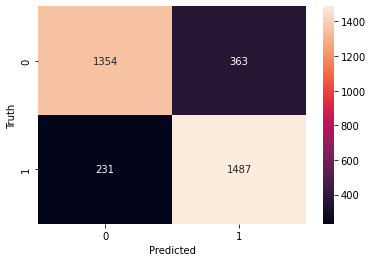

In [21]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [22]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1717
           1       0.80      0.87      0.83      1718

    accuracy                           0.83      3435
   macro avg       0.83      0.83      0.83      3435
weighted avg       0.83      0.83      0.83      3435

